# Morenney Rock Glacier Radar Imagery Example

## Prepare Data for Bulk Download

Akhdefo processes radar imagery that has been corrected for radiometric and terrain distortions. Its function, 'download_RTC,' enables the downloading of Synthetic Aperture Radar (SAR) products from ASF's HyP3 platform. Users can easily order RTC, AutoRIFT, and InSAR products with just a few lines of Python script.
Firstly, users are advised to visit [ASF's website](https://search.asf.alaska.edu/#/?maxResults=250) to download metadata for their chosen time-series product granules. To assist users, example screenshots are provided below as a guide to navigate through the process.


![Step 1](data/asf1.png)


![Step 1](data/asf2.png)

## Import AkhDefo Packages.

In [ ]:

#Functions for data preparations
import akhdefo_functions
from akhdefo_functions import download_RTC
from akhdefo_functions import read_data_prep
from akhdefo_functions import move_files_with_string
from akhdefo_functions import Crop_to_AOI

#Functions data processing
from akhdefo_functions import scatter_area_mask
from akhdefo_functions import Raster_Correction
from akhdefo_functions import Optical_flow_akhdefo

#Functions for shapefile point data interpolation to raster geotif
#Function Autovariogram use Kriging method it fits the data to different variogram models and automatically use the best fit variogram model (Computationally Heavy but you can process data in chunks)
from akhdefo_functions import Auto_Variogram

# interpoate_xyz uses the following interpolation methods (nearest, linear and cubic)
from akhdefo_functions import interpolate_xyz

#Functions for data Visualization and Analysis
from akhdefo_functions import MeanProducts_plot_ts
from akhdefo_functions import plot_stackNetwork
from akhdefo_functions import akhdefo_viewer
from akhdefo_functions import akhdefo_dashApp

## Download Data using EarthData ASF Account

In [ ]:

''' 

First Run the below command and make sure {download=False} to see the granule paths and frames. 

Its highly recommended to use data frame same path for the entire time-series for more accurate results
 
'''


# download_RTC( prompt=True, asf_datapool_results_file= './data/morenny/radar/asf-datapool-results-2023-12-19_04-01-18.csv', 
#             save_dir= './data/morenny/radar/path129', job_name= './data/morenny/radar/RockGlacier_asc', 
#             dem_matching= False, 
#             include_dem= False, 
#             include_inc_map= True, 
#             include_rgb = False, 
#             include_scattering_area= True, 
#             scale = 'power', 
#             resolution = 20, 
#             speckle_filter= False,
#             radiometry='gamma0',
#             dem_name='copernicus', limit=None , download=False , path_number=129, RTC=False)

## Extract downloaded zip files

In [ ]:
#This functions extracts data from all the granuples zip directory.
read_data_prep(zip_dir='./data/morenny/radar/path129_rtc/',
                                 image_dir='./data/morenny/radar/RS_dir_path129', 
                                 ext_image_file='VV.tif', udm_mask_dir='./data/morenny/radar/scatter_dir', ext_udm_mask_file='area.tif')

In [ ]:
# This function will move all the data from each granules subdir to a single folder
move_files_with_string(source_dir='./data/morenny/radar/RS_dir_path129', dest_dir='./data/morenny/radar/RS_path129', search_string='.tif')
move_files_with_string(source_dir='./data/morenny/radar/scatter_dir', dest_dir='./data/morenny/radar/scatter_rs', search_string='area.tif')


In [ ]:
'''  
Optional:

Create an accumulated scatter area mask from a set of raster images based on a given threshold. 
the input dataset is taken from ASF RTC processing.
The scattering area for each pixel in the RTC image in square meters. 
The values are calculated based on the effectively illuminated gamma-0 terrain surface using a digital elevation model,
the local incidence angle map, and the layover-shadow map. see detailes 
at the following website https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#scattering-area-map
The function processes each raster image in the input folder, crops it based on the provided AOI from the shapefile,
normalizes the cropped raster, and then converts the normalized image to a binary mask based on the scatter_percentageArea_threshold. 
The binary masks from each raster are then accumulated to generate the final scatter area mask.

'''

input_folder = "./data/morenny/radar/scatter_rs"
output_folder = "./data/morenny/radar/scatter_masks_20"
plot_folder = "./data/morenny/radar/scatter_mask_plots_20"
shapefile_path = "./data/morenny/AOI.shp"
scatter_Area_threshold=5
vegetation_mask_path=None


#scatter_area_mask(input_folder, output_folder, plot_folder, shapefile_path, scatter_Area_threshold, vegetation_mask_path)



In [ ]:

''' 
Crop all raster to Area of interest bounding box


'''
Crop_to_AOI(Path_to_WorkingDir='./data/morenny/radar/RS_path129/', 
                              Path_to_AOI_shapefile='./data/morenny/AOI.shp', 
                              output_CroppedDir='./data/morenny/radar/RS_cropped_path129', file_ex='.tif')



## Preparing raster for optical flow and displacement calculation!

By deafult RTC data comes in the below three formats. The below raster correction function converts the below RTC data formats to Unassigned 8 bit integer("uint8").

- Power Scale: SAR images in the power scale represent the square of the amplitude. Power is a measure of the energy of the radar signal returned from each point on the ground. It's more intuitive in terms of energy interpretation but less used for visual interpretation due to its non-linear nature.

- Amplitude Scale: The amplitude scale is a direct representation of the radar signal's strength received from each point. It's more commonly used for visual interpretation since it's more linear than the power scale. Amplitude images are easier to interpret but can be sensitive to noise.

- Decibel (dB) Scale: The decibel scale is a logarithmic scale used to express SAR data. It's derived from the amplitude or power scale and is used to compress the dynamic range of the SAR data. The dB scale is beneficial for enhancing certain features in the data, especially in areas with very high or very low backscatter.


In [ ]:
import warnings
warnings.filterwarnings("ignore")


Raster_Correction(input_path="./data/morenny/radar/RS_cropped_path129", output_path="./data/morenny/radar/RS_cropped_path129_filt", limit=None,
                                    lowpass_kernel_size=None, bilateral_win_size=7, bilateral_sigma_color=75,
                                    bilateral_sigma_spatial=75,
                                    clip_percentiles=[2, 98], optical=False, 
                                    scale='power', Vegetation_mask=None)

## Applying optical flow and producing time-series deformation products.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
Optical_flow_akhdefo(input_dir='./data/morenny/radar/RS_cropped_path129_filt', output_dir='./data/morenny/radar/geo_path129', AOI='./data/morenny/AOI.shp', zscore_threshold=2, 
                                       ssim_thresh=0.6, image_resolution='20m', interpolate='kriging', 
                                       show_figure=False, point_size=2, dem_path='./data/morenny/dem.tif', smoothing_kernel_size=None, 
                                       Vegetation_mask=None, VEL_scale='year', VEL_Mode='linear', good_match_option=0.75, 
                                       hillshade_option=True, shapefile_output=True, max_triplet_interval=300, pixel_size=20, num_chunks=1, overlap_percentage=0, pyr_scale=0.5, levels=15, 
                                       winsize=128, iterations=7, poly_n=7, poly_sigma=1.5,
                                       flags=1, master_reference='single', 
                                       selection_Mode='pair', start_date=None, end_date=None, krig_method='universal', spatial_ref=True)

## Interpolate and Create raster Velocities

In [ ]:
import akhdefo_functions
from akhdefo_functions import Auto_Variogram

Auto_Variogram(data='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_N.shp', column_attribute='VEL'
               , pixel_size=20, num_chunks=1, out_fileName='N', geo_folder='./data/morenny/radar/VEL_Folder', plot_folder='./data/morenny/radar/VEL_Folder'
               , smoothing_kernel=3, latlon=False, aoi_shapefile='./data/morenny/AOI.shp' ,  krig_method='simple')


Auto_Variogram(data='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_E.shp', column_attribute='VEL'
               , pixel_size=20, num_chunks=1, out_fileName='E', geo_folder='./data/morenny/radar/VEL_Folder', plot_folder='./data/morenny/radar/VEL_Folder'
               , smoothing_kernel=3, latlon=False, aoi_shapefile='./data/morenny/AOI.shp',  krig_method='simple')



Auto_Variogram(data='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_2DVEL.shp', column_attribute='VEL'
               , pixel_size=20, num_chunks=1, out_fileName='2DVEL', geo_folder='./data/morenny/radar/VEL_Folder', plot_folder='./data/morenny/radar/VEL_Folder'
               , smoothing_kernel=3, latlon=False, aoi_shapefile='./data/morenny/AOI.shp',  krig_method='simple')



Auto_Variogram(data='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_2DVEL.shp', column_attribute='aspect'
               , pixel_size=20, num_chunks=1, out_fileName='aspect', geo_folder='./data/morenny/radar/VEL_Folder', plot_folder='./data/morenny/radar/VEL_Folder'
               , smoothing_kernel=3, latlon=False, aoi_shapefile='./data/morenny/AOI.shp',  krig_method='simple')

## Visualize Displacement Products

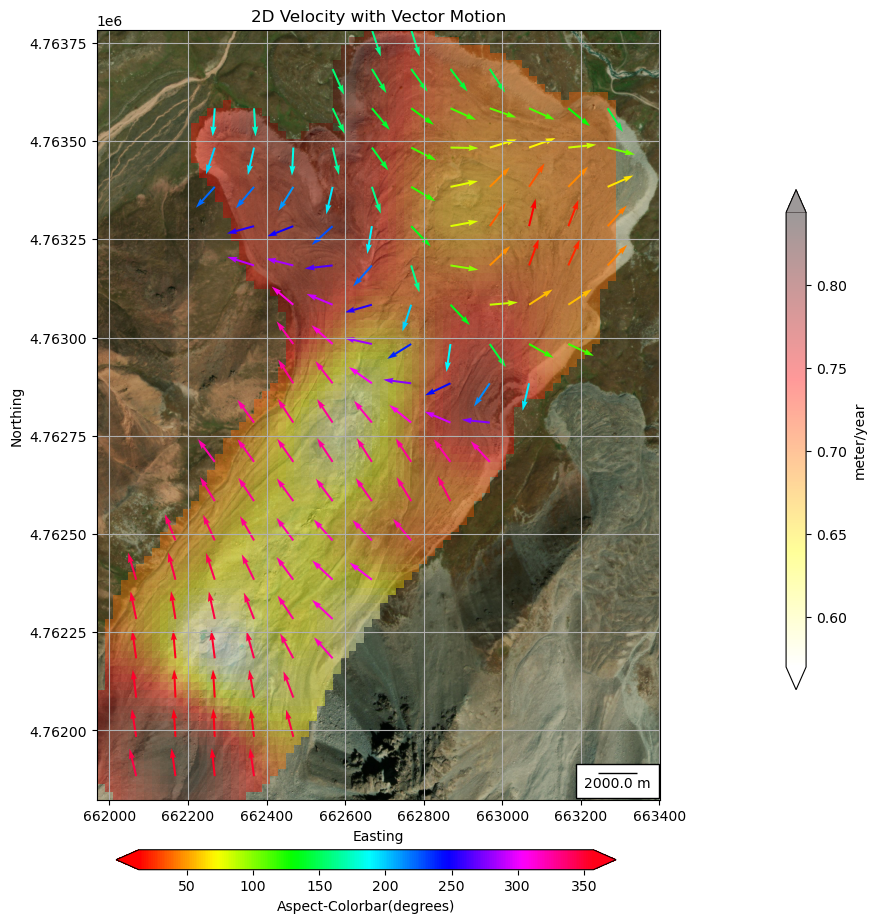

In [8]:
import akhdefo_functions
import cmocean.cm as cmo

akhdefo_functions.akhdefo_viewer(path_to_dem_file='./data/morenny/basemap.tif', raster_file='./data/morenny/radar/VEL_Folder/2DVEL.tif', output_folder='./data/morenny/radar/Figs_analysis/', title='2D Velocity with Vector Motion', 
                   pixel_resolution_meters=None, output_file_name="2DVEL_WithVectorMotion.png", 
                   alpha=0.4, unit_conversion=None, no_data_mask=True, 
                   colormap='hot_r', min_value=None, max_value=None, 
                   normalize=True, colorbar_label='meter/year', show_figure=True, aspect_raster='./data/morenny/radar/VEL_Folder/aspect.tif', cmap_aspect='hsv' , step=5)

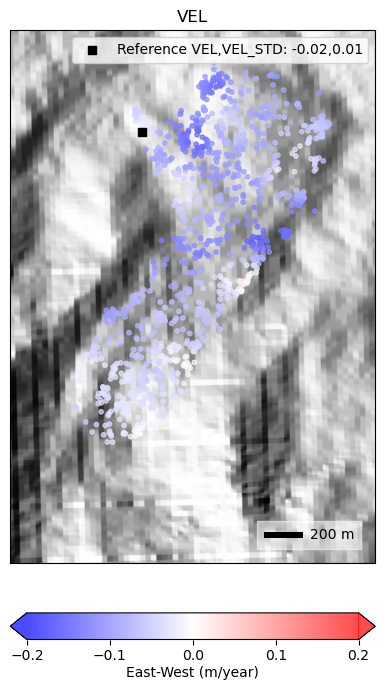

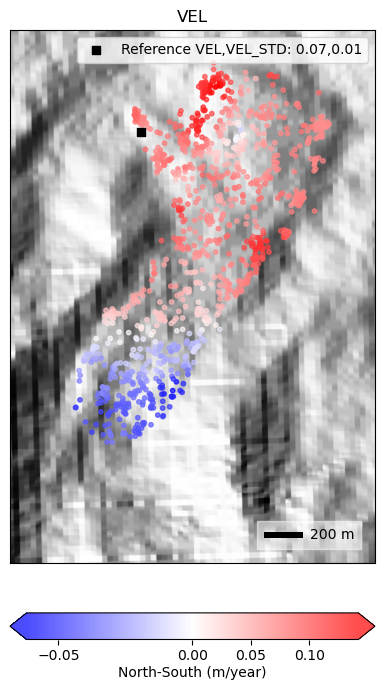

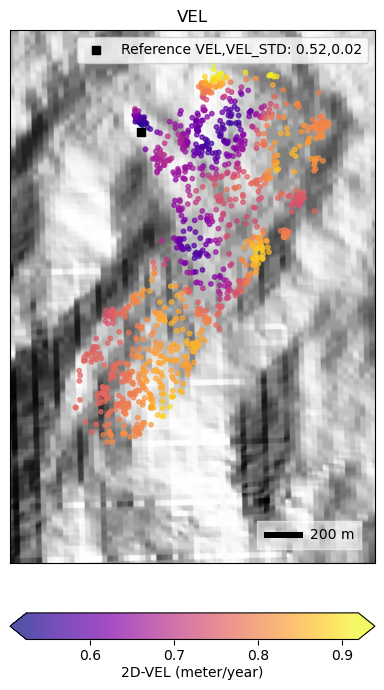

In [7]:
#Visualize Mean Velocity East-West
# if set batch_plot=True it will plot static time series figure for each date acquisition 

akhdefo_functions.MeanProducts_plot_ts(path_to_shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_E.shp', 
                                       dem_path='./data/morenny/dem.tif', out_folder='./data/morenny/radar/Figs_analysis/E', 
                                       color_field="VEL", Set_fig_MinMax=True, 
                                       MinMaxRange=[-0.2, 0.2], opacity=0.7,
                                       cmap='bwr', point_size=10, 
                                       cbar_label='East-West (m/year)', 
                                       batch_plot=False)

#Visualize Mean Velocity North-South
akhdefo_functions.MeanProducts_plot_ts(path_to_shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_N.shp', 
                                       dem_path='./data/morenny/dem.tif', out_folder='./data/morenny/radar/Figs_analysis/N', 
                                       color_field="VEL", Set_fig_MinMax=False, 
                                       MinMaxRange=[0, 1.5], opacity=0.7,
                                       cmap='bwr', point_size=10, 
                                       cbar_label='North-South (m/year)', 
                                       batch_plot=False)

#Visualize Mean Velocity 2D Velocity 
akhdefo_functions.MeanProducts_plot_ts(path_to_shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_2DVEL.shp', 
                                       dem_path='./data/morenny/dem.tif', out_folder='./data/morenny/radar/Figs_analysis/2D', 
                                       color_field="VEL", Set_fig_MinMax=False, 
                                       MinMaxRange=[-0.5, 0.5], opacity=0.7,
                                       cmap='plasma', point_size=10, 
                                       cbar_label='2D-VEL (meter/year)', 
                                       batch_plot=False)

## Interactive Time Series Analysis in a Dash Web App

This plot is part of an interactive web application. Users have the ability to select groups of data points using either the box select or lasso tool, which are superimposed on a satellite image base map. The selected data will then be reflected in the time series chart. Additionally, users can customize the axis labels to suit their dataset; for example, if the dataset measures displacement or velocity in meters, the y-axis label can be adjusted accordingly from the default mm. Furthermore, users can download their analysis and the generated figures directly from the web application.

![dash2d_radar output sample](./data/morenny/radar/dash2d1.png)

![dash2d_radar output sample1](./data/morenny/radar/newplot111.png)

![dash2d_radar output sample2](./data/morenny/radar/newplot12.png)

In [ ]:


akhdefo_dashApp(
Path_to_Shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_2DVEL.shp',
                                  port=8057, BaseMap=True, basemap_type='image')

In [ ]:

akhdefo_dashApp(
Path_to_Shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_N.shp',
                                  port=8056, BaseMap=True, basemap_type='image')

In [ ]:

akhdefo_dashApp(
Path_to_Shapefile='./data/morenny/radar/geo_path129/temp_shapefile_dir/updated_shapefiles/20150717_20230921_20230921_E.shp',
                                  port=8055, BaseMap=True, basemap_type='image')

## Plot Mean Land Surface Temperature for months July and August 2017 to 2021

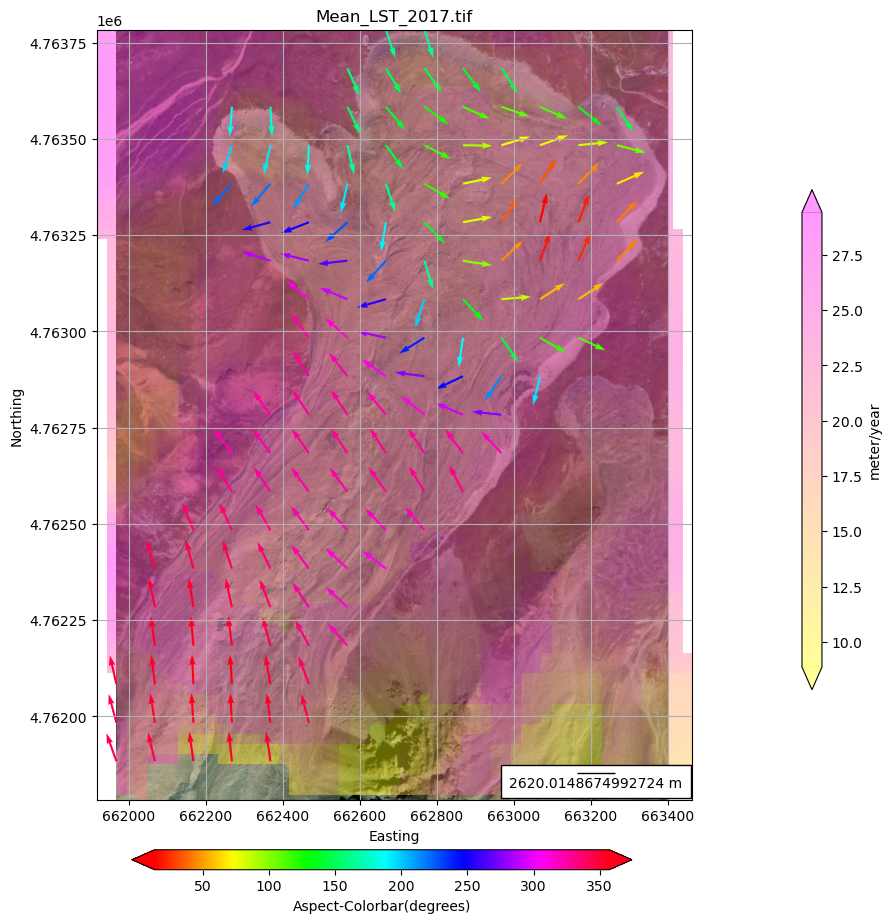

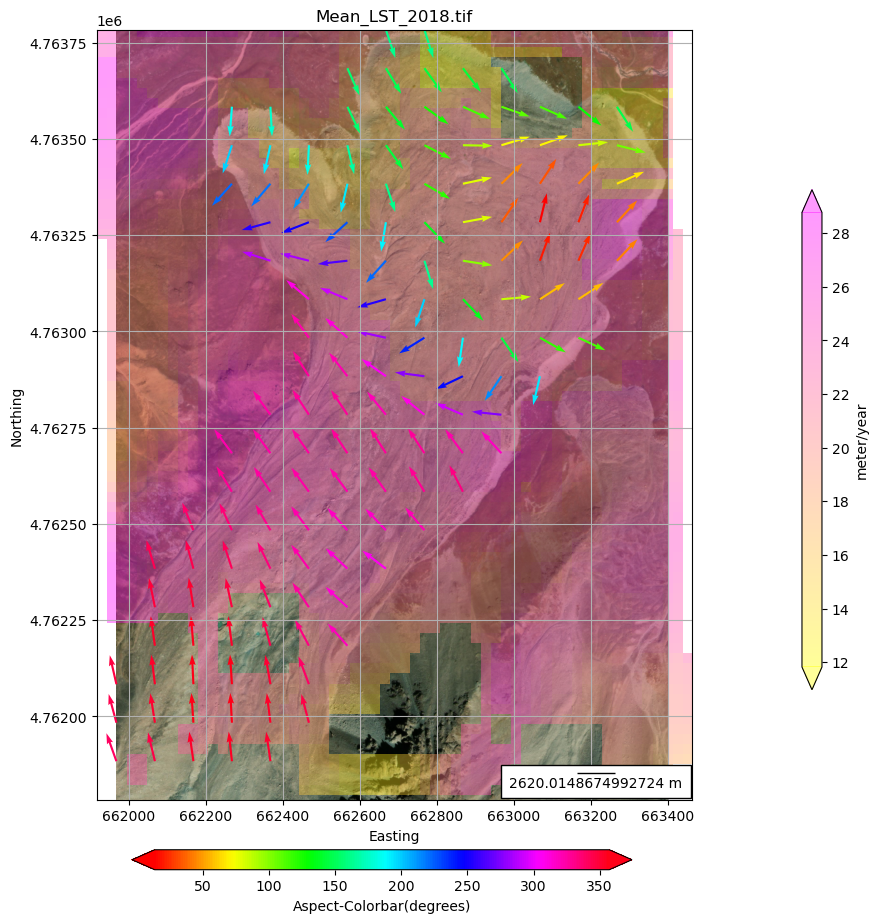

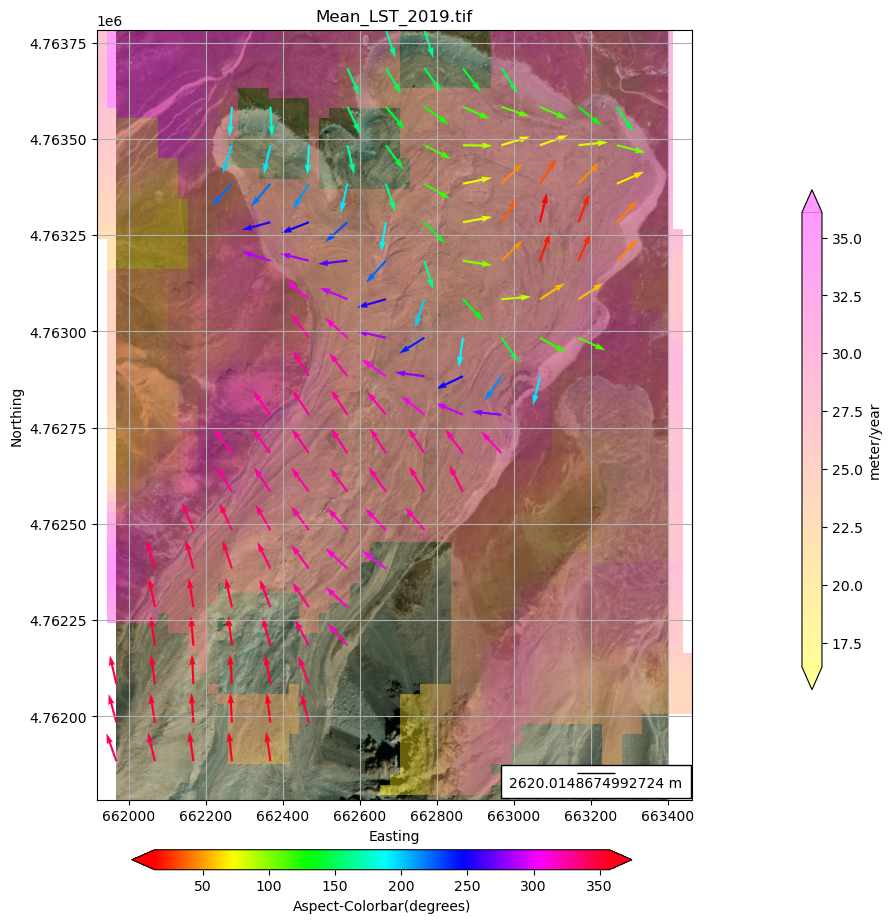

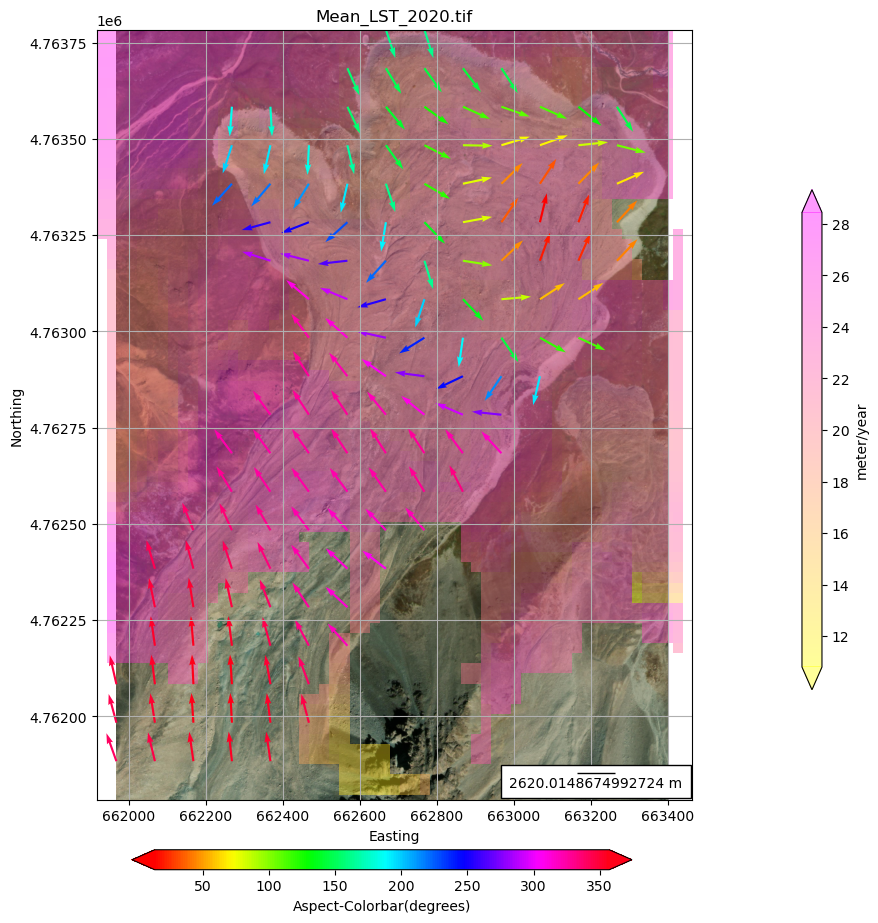

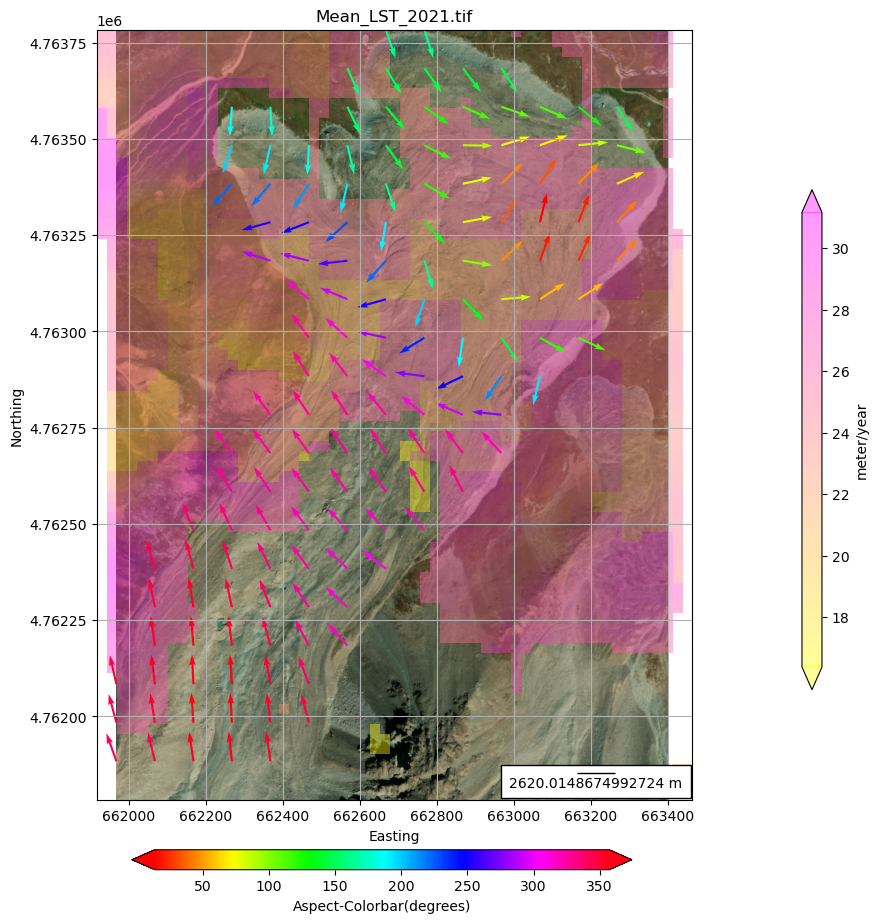

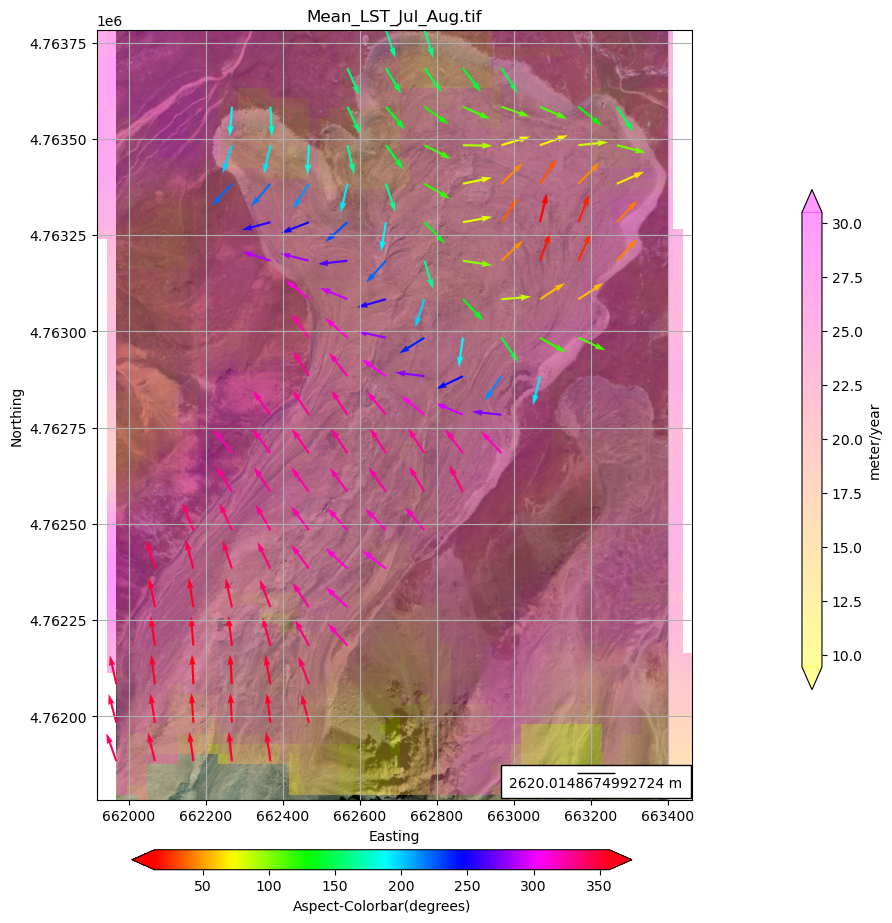

In [6]:
import os
import akhdefo_functions
from osgeo import gdal
import tempfile
import numpy as np 
import datetime
import re
import pandas as pd
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For enhanced plot styling
from scipy.stats import linregress
import geopandas as gpd 
directory_path = './data/morenny/LST/'
basemap_path = './data/morenny/basemap.tif'

# Read the projection from the basemap
basemap_ds = gdal.Open(basemap_path)
basemap_proj = basemap_ds.GetProjection()

# List all files in the specified path
entries = os.listdir(directory_path)

mean_values = []
filenames = []

dates=[]
date_pattern = r'\d{4}\d{2}\d{2}'  # Adjust this pattern based on your filename date format

def extract_year_from_string(s):
    # Regular expression pattern to find a four-digit year
    pattern = r'\d{4}'
    match = re.search(pattern, s)

    if match:
        # Return the matched year
        return match.group()
    else:
        return None

# Test the function
       
for f in entries:
    full_path = os.path.join(directory_path, f)
    if full_path.endswith('.tif'):
        file_name = os.path.basename(full_path)

        # Create a temporary file for the reprojected raster
        temp_outputname = os.path.join(tempfile.gettempdir(), f'reprojected_{file_name}')

        # Reproject the raster to match the basemap's projection
        gdal.Warp(destNameOrDestDS=temp_outputname,
                  srcDSOrSrcDSTab=full_path,
                  dstSRS=basemap_proj)
        
        ####################
         # Open the reprojected raster and calculate its mean
        ds = gdal.Open(temp_outputname)
        band = ds.GetRasterBand(1)
        data = band.ReadAsArray()
        mean_value = np.nanmean(data)  # Exclude no-data values
        filenames.append(file_name)
        match = re.search(date_pattern, file_name)
        year=extract_year_from_string(file_name)
        mean_values.append(mean_value)
        dates.append(year)
        
        #################
        
        # Call your custom function with the necessary parameters
        akhdefo_functions.akhdefo_viewer(
            path_to_dem_file='./data/morenny/basemap.tif',
            raster_file=temp_outputname,
            output_folder='./data/morenny/radar/Figs_analysis/',
            title=file_name,
            pixel_resolution_meters=None,
            output_file_name=file_name,
            alpha=0.4,
            unit_conversion=None,
            no_data_mask=True,
            colormap='spring_r',
            min_value=None,
            max_value=None,
            normalize=True,
            colorbar_label='meter/year',
            show_figure=True,
            aspect_raster='./data/morenny/radar/VEL_Folder/aspect.tif',
            cmap_aspect='hsv',
            step=5
        )

        ds = None
        band=None
        os.remove(temp_outputname)
         # Find date in the filename


In [10]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For enhanced plot styling
from scipy.stats import linregress
import geopandas as gpd 


# Initialize the Earth Engine module.
ee.Initialize()

# Define your area of interest (AOI) using latitude and longitude
lat = 42.99
lon = 76.99
point = ee.Geometry.Point([lon, lat])

# Define a 5km by 5km square around the point
#square = point.buffer(500).bounds()  # Buffer by 4000 meters (4 km) and get bounds
square=ee.Geometry.BBox(76.9868751901, 42.9914296961, 77.0048813882, 43.0093232151)



# Cloud mask function
def maskL8sr(col):
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    qa = col.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return col.updateMask(mask)

# Load and process the Landsat 8 Image Collection
col = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').map(maskL8sr).filterDate('2017-03-01', '2024-10-01').filterBounds(square)

# Function to calculate LST for each image in the collection
def calculateLST(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    a = ee.Number(0.004)
    b = ee.Number(0.986)
    LST = image.expression('(Tb/(1 + (0.00115 * (Tb / 1.438)) * log(Ep)))-273.15', {
      'Tb': image.select('B10').multiply(0.1),
      'Ep': ndvi.multiply(a).add(b)
    }).rename('LST')
    return image.addBands(LST)

# Add LST band to each image in the collection
lstCol = col.map(calculateLST)

# Function to add a 'year' property to each image
def addYear(image):
    date = ee.Date(image.get('system:time_start'))
    year = ee.Number(date.get('year')).toInt()
    return image.set('year', year)

# Apply the addYear function to each image in the collection
lstCol = lstCol.map(addYear)

# Filter for July and August
julAugCol = lstCol.filter(ee.Filter.calendarRange(7, 8, 'month'))
julAugCol=lstCol


# Calculate the mean LST for each year
yearlyMean = ee.ImageCollection.fromImages(
  ee.List.sequence(2017, 2023).map(lambda year: 
    julAugCol.filter(ee.Filter.eq('year', year)).mean().set('year', year)
  )
)

# Function to extract data
def extract_data(image):
    mean_dict = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=square, scale=30).getInfo()
    return mean_dict.get('LST', None)  # Use get method with a default value of None

# Extract the mean LST for each year and convert to a Pandas DataFrame
data = []
years = []
for year in range(2017, 2021):
    image = ee.Image(yearlyMean.filter(ee.Filter.eq('year', year)).first())
    lst_value = extract_data(image)
    if lst_value is not None:
        data.append(lst_value)
        years.append(year)

df = pd.DataFrame({'Year': years, 'LST': data})


import pandas as pd
import plotly.graph_objects as go
import plotly.express as px


# Fitting a linear model to the data
slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['LST'])

# Calculate the line of best fit
df['Trendline'] = intercept + slope * df['Year']

# Create a Plotly figure
fig = px.scatter(df, x='Year', y='LST', title='Mean LST for July and August (2017-2021) with Trendline')

# Add a scatter plot for Mean LST
fig.add_trace(go.Scatter(x=df['Year'], y=df['LST'], mode='markers', name='Mean LST'))

# Add a trendline
fig.add_trace(go.Scatter(x=df['Year'], y=df['Trendline'], mode='lines', name='Trendline'))

# Calculate the rate of change annotation
rate_of_change = slope

# Annotate the rate of change in the legend
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=0),
                         name=f'Rate of Change: {rate_of_change:.2f}°C/year'))

# Customize the appearance
fig.update_traces(marker=dict(size=8))
fig.update_layout(legend_title_text='Legend')

# Show the plot
fig.show()

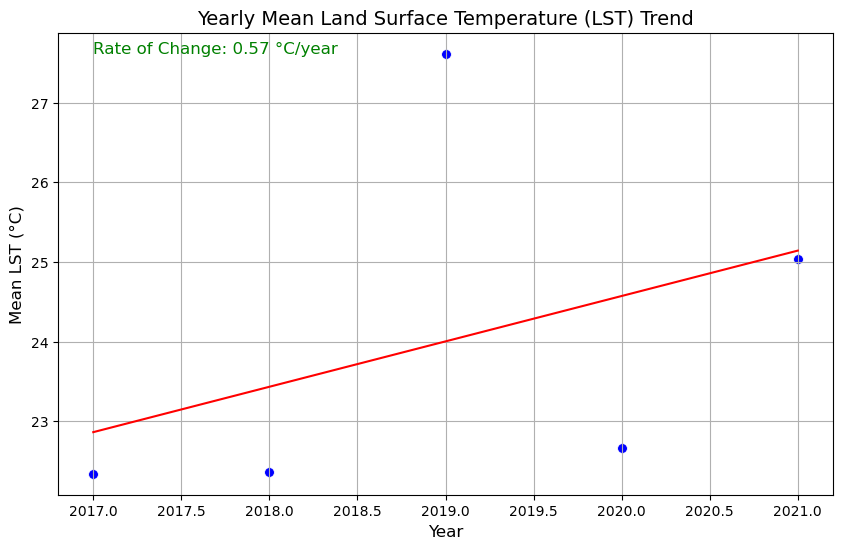

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

# Load the CSV file
file_path = './data/morenny/LST/Mean_LST_Jul_Aug_2017_to_2023.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

# Selecting relevant columns
data = data[['year', 'LST']]

# Removing any null/NaN values
data.dropna(inplace=True)

# Ensuring 'year' is an integer
data['year'] = data['year'].astype(int)

# Correcting the line plot code
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='year', y='LST', color='blue', s=50)

# Plotting the regression line
sns.lineplot(x=data['year'], y=line, color='red')

# Annotating the rate of change
rate_of_change = f"Rate of Change: {slope:.2f} °C/year"
plt.text(data['year'].min(), data['LST'].max(), rate_of_change, fontsize=12, color='green')

# Setting plot titles and labels
plt.title('Yearly Mean Land Surface Temperature (LST) Trend', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean LST (°C)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()


